# Construct Leontief's inverse

In this notebook we construct the Leontief inverse matrix using the worldwide IO tables provided by the OECD. To see how the Leontief matrix is relevant, note that the $(i; j)$ element of the Leontief inverse, $l_{ij}$ measures the importance of industry $j$ as a direct and indirect input-supplier to industry $i$ in the economy. Furthermore, $l_{ij}$ accounts for all possible directed walks (of various lengths) that connect industry $j$ to industry $i$ over the network.

The process to construct these tables is as follows: 
- First, we take the matrix of trade flows between sectors (the raw table that we get from the OECD), which we call Z, and aggregate all non-essential sectors. 
- Second, we construct the column vector x, which represents the total production by sector. 
- Third, we combine x and Z to get matrix A, which gives us the coefficients IO table. The difference between A and Z is that Z represents trade flows, whereas A represents the input linkages in terms of relative proportions (assuming a Cobb-Douglas production function). 
- Finally, we construct the Leontief inverse L from A.

To know more about these matrices and their meaning, this [paper](http://vasco-m-carvalho.github.io/pdfs/ProductionNetworks.pdf) by Carvalho and Tahbaz-Salehi (2018) is a good reference. The notation for A and L is the same. Z is referred to as trade flows matrix. x is not explicitly mentioned.

In [2]:
# Imports and path
import pymrio
import pandas as pd
import numpy as np
from pathlib import Path
oecd_storage = Path('/project_data/data_asset/')

In [3]:
# Select the year to parse - 2015 in this case
oecd_path_year = pymrio.parse_oecd(path=oecd_storage, year=2015)

## 1. Matrix Z
Firs, we read the OECD tables and format them to get the matrix representing the direct relations between the sectors. We'll call this matrix Z. Some non-essential sectors are aggregated.

In [4]:
countries = oecd_path_year.get_regions()
non_essential_sectors = ['07T08','24','25','29','30','68']

In [5]:
# Get Input-Output table
Z = oecd_path_year.Z.copy()
Z.shape

(2340, 2340)

In [6]:
# Collapse non-essential columns
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        column = Z[(country, sector)]
        country_NE = pd.concat([country_NE, column], axis = 1)
        Z.drop(columns = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Z[(country, 'All non-essential')] = country_NE
    
    country_NE = pd.DataFrame()

In [7]:
# Collapse non-essential rows
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        row = Z.loc[(country, sector),:]
        country_NE = pd.concat([country_NE, row], axis = 1)
        Z.drop(index = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Z.loc[(country, 'All non-essential'),:] = country_NE
    
    country_NE = pd.DataFrame()

In [8]:
Z

region                             ARG                                         \
sector                           01T03        05T06          09         10T12   
region sector                                                                   
ARG    01T03              13014.595854     8.049052    4.143001  34292.771836   
       05T06                199.321049  2276.678829  275.113858    254.403159   
       09                   313.959066  1894.970278  246.435218     39.008104   
       10T12               1960.104890    31.815860    5.132780   4438.490860   
       13T15                257.570464    39.774788    6.260411    435.065366   
...                                ...          ...         ...           ...   
TUR    All non-essential      0.685614     0.598314    0.157233      0.842223   
TWN    All non-essential      0.687945     1.416402    0.288667      1.680883   
USA    All non-essential      8.382023     8.336595    1.382335     13.529736   
VNM    All non-essential      0.131674     0.124189    0.040799      0.130207   
ZAF    All non-essential      0.614518     0.725694    0.140749      0.981533   

region                                                                       \
sector                          13T15          16       17T18            19   
region sector                                                                 
ARG    01T03               964.672923  545.773454  240.085264     16.713493   
       05T06                34.275764    7.246904   81.646943  16381.766599   
       09                    0.000000    2.405210   12.716208     14.148393   
       10T12               243.163011   22.569292   88.041559     21.605191   
       13T15              6610.432902   26.232974   76.357137     13.831488   
...                               ...         ...         ...           ...   
TUR    All non-essential     0.246083    0.109768    0.220764      0.101895   
TWN    All non-essential     0.348774    0.223092    0.182624      0.147612   
USA    All non-essential     4.146243    1.715818    2.447097      1.464879   
VNM    All non-essential     0.032578    0.015670    0.042467      0.020378   
ZAF    All non-essential     0.247062    0.139073    0.224580      1.151624   

region                                            ...               SVK  \
sector                         20T21          22  ... All non-essential   
region sector                                     ...                     
ARG    01T03              324.245670  215.505180  ...          0.001767   
       05T06              757.582323  101.862709  ...          0.000014   
       09                   6.509650   22.030458  ...          0.000000   
       10T12              173.685120   50.899412  ...          0.004491   
       13T15              136.254071  166.691463  ...          0.007941   
...                              ...         ...  ...               ...   
TUR    All non-essential    0.998359    0.401875  ...        130.833868   
TWN    All non-essential    0.304447    0.683925  ...         20.721855   
USA    All non-essential    7.432188    5.586056  ...         92.617364   
VNM    All non-essential    0.302031    0.054106  ...          2.665338   
ZAF    All non-essential    0.459515    0.440182  ...          5.229450   

region                                 SVN               SWE  \
sector                   All non-essential All non-essential   
region sector                                                  
ARG    01T03                      0.001402          0.007053   
       05T06                      0.000168          0.001535   
       09                         0.000068          0.008444   
       10T12                      0.006811          0.059601   
       13T15                      2.121081          0.046811   
...                                    ...               ...   
TUR    All non-essential         48.773332        258.958440   
TWN    All non-essential          6.550438         54.306799   
USA

## 2. Column vector x
The package pymrio has a method to construct x. It needs the industries' final demands, Y, and Z. We need to collapse the final demand from non-essential sectors before combining Z and Y.

In [9]:
Y =  oecd_path_year.Y.copy()
Y.shape

(2340, 390)

In [10]:
# Collapse non-essential rows
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        row = Y.loc[(country, sector),:]
        country_NE = pd.concat([country_NE, row], axis = 1)
        Y.drop(index = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Y.loc[(country, 'All non-essential'),:] = country_NE
    
    country_NE = pd.DataFrame()

In [11]:
Y

region                            AUS                                       \
category                         HFCE         NPISH      GGFC         GFCF   
region sector                                                                
ARG    01T03                11.366570  7.287708e-05  0.131699     0.339103   
       05T06                 0.012376  8.705474e-04  0.001273     0.002124   
       09                    0.000000  0.000000e+00  0.022305     0.000000   
       10T12               137.585967  2.149185e-03  0.006469     0.052593   
       13T15                 2.241664  3.249891e-04  0.006239     0.035196   
...                               ...           ...       ...          ...   
TUR    All non-essential    24.301541  2.850192e-04  0.053436    35.846751   
TWN    All non-essential    67.533368  0.000000e+00  0.022906   127.517014   
USA    All non-essential  1009.101133  0.000000e+00  3.273139  1563.525279   
VNM    All non-essential    44.473134  1.013181e-08  0.001189   149.884870   
ZAF    All non-essential   123.108104  1.820305e-03  0.005881   145.806010   

region                                                   AUT                \
category                       INVNT         P33        HFCE         NPISH   
region sector                                                                
ARG    01T03                0.023036    0.184462    2.376076  4.573915e-04   
       05T06                0.000024    0.001111    0.002881  4.920475e-07   
       09                   0.000000    0.000000    0.000000  0.000000e+00   
       10T12                0.001955    0.615711   12.107784  6.231809e-03   
       13T15                0.000759    0.394051   19.071373  6.302818e-06   
...                              ...         ...         ...           ...   
TUR    All non-essential    2.553650    6.283448   52.186839  1.739656e-04   
TWN    All non-essential    8.159273   10.785262   12.274567  0.000000e+00   
USA    All non-essential  110.434040  324.200263  113.898130  9.170612e-06   
VNM    All non-essential    8.420089   16.560069    1.711115  4.324486e-08   
ZAF    All non-essential   11.801682   13.003463    5.141306  0.000000e+00   

region                                           ...        VNM               \
category                       GGFC        GFCF  ...       GGFC         GFCF   
region sector                                    ...                           
ARG    01T03               0.206733    0.103018  ...   0.000266     7.014603   
       05T06               0.006822    0.000070  ...   0.001222     0.000824   
       09                  0.001071    0.000000  ...   0.000000     0.000000   
       10T12               0.328795    0.017504  ...   0.001465     0.151709   
       13T15               0.015962    0.032542  ...   0.000447     0.079269   
...                             ...         ...  ...        ...          ...   
TUR    All non-essential   0.419416   71.202167  ...   0.000359     2.221153   
TWN    All non-essential   4.515330   16.386541  ...   0.004486    17.713198   
USA    All non-essential  30.206520  159.747740  ...   0.020296   393.065209   
VNM    All non-essential   0.955537    3.186978  ...  34.189594  4825.960860   
ZAF    All non-essential   0.503763    5.533335  ...   0.000900     0.235764   

region                                                     ROW            \
category                         INVNT        P33         HFCE     NPISH   
region sector                                                              
ARG    01T03             -2.513391e-07   0.149529  1021.027571  0.233798   
       05T06             -2.195817e-09   0.000922     0.757555  0.003935   
       09                 0.000000e+00   0.000000     0.000000  0.000000   
       10T12             -5.247771e-08   0.551082  2369.637263  2.174819   
       13T15             -1.140908e-07   0.399597    43.370771  0.009096   
...                                ...        ...          ...       ...   
TUR    Al

We can now combine matrices Z and Y to produce the total outputs vector x.

In [12]:
x = pymrio.calc_x(Z, Y)
x

indout
region sector                         
ARG    01T03              8.834342e+04
       05T06              3.053964e+04
       09                 4.231662e+03
       10T12              9.322885e+04
       13T15              3.331857e+04
...                                ...
TUR    All non-essential  2.177646e+05
TWN    All non-essential  1.552781e+05
USA    All non-essential  4.661483e+06
VNM    All non-essential  5.348071e+04
ZAF    All non-essential  1.011248e+05

[2015 rows x 1 columns]

## 3. Coefficients matrix A
Once we have x and Z, we can move on to calculate A.

In [13]:
A = pymrio.calc_A(Z, x)
A

region                         ARG                                \
sector                       01T03     05T06        09     10T12   
region sector                                                      
ARG    01T03              0.147318  0.000264  0.000979  0.367834   
       05T06              0.002256  0.074548  0.065013  0.002729   
       09                 0.003554  0.062050  0.058236  0.000418   
       10T12              0.022187  0.001042  0.001213  0.047609   
       13T15              0.002916  0.001302  0.001479  0.004667   
...                            ...       ...       ...       ...   
TUR    All non-essential  0.000008  0.000020  0.000037  0.000009   
TWN    All non-essential  0.000008  0.000046  0.000068  0.000018   
USA    All non-essential  0.000095  0.000273  0.000327  0.000145   
VNM    All non-essential  0.000001  0.000004  0.000010  0.000001   
ZAF    All non-essential  0.000007  0.000024  0.000033  0.000011   

region                                                                    \
sector                           13T15        16     17T18            19   
region sector                                                              
ARG    01T03              2.895301e-02  0.069370  0.015863  4.519929e-04   
       05T06              1.028729e-03  0.000921  0.005395  4.430218e-01   
       09                 0.000000e+00  0.000306  0.000840  3.826234e-04   
       10T12              7.298123e-03  0.002869  0.005817  5.842820e-04   
       13T15              1.984009e-01  0.003334  0.005045  3.740532e-04   
...                                ...       ...       ...           ...   
TUR    All non-essential  7.385772e-06  0.000014  0.000015  2.755601e-06   
TWN    All non-essential  1.046785e-05  0.000028  0.000012  3.991968e-06   
USA    All non-essential  1.244424e-04  0.000218  0.000162  3.961560e-05   
VNM    All non-essential  9.777839e-07  0.000002  0.000003  5.510937e-07   
ZAF    All non-essential  7.415139e-06  0.000018  0.000015  3.114406e-05   

region                                        ...               SVK  \
sector                       20T21        22  ... All non-essential   
region sector                                 ...                     
ARG    01T03              0.011950  0.011587  ...      3.711947e-08   
       05T06              0.027920  0.005477  ...      2.904252e-10   
       09                 0.000240  0.001184  ...      0.000000e+00   
       10T12              0.006401  0.002737  ...      9.437189e-08   
       13T15              0.005021  0.008962  ...      1.668580e-07   
...                            ...       ...  ...               ...   
TUR    All non-essential  0.000037  0.000022  ...      2.749095e-03   
TWN    All non-essential  0.000011  0.000037  ...      4.354098e-04   
USA    All non-essential  0.000274  0.000300  ...      1.946086e-03   
VNM    All non-essential  0.000011  0.000003  ...      5.600436e-05   
ZAF    All non-essential  0.000017  0.000024  ...      1.098818e-04   

region                                 SVN               SWE  \
sector                   All non-essential All non-essential   
region sector                                                  
ARG    01T03                  1.124635e-07      4.929813e-08   
       05T06                  1.348592e-08      1.072703e-08   
       09                     5.446797e-09      5.901652e-08   
       10T12                  5.464382e-07      4.165758e-07   
       13T15                  1.701794e-04      3.271827e-07   
...                                    ...               ...   
TUR    All non-essential      3.913202e-03      1.809969e-03   
TWN    All non-essential      5.255574e-04      3.795730e-04   
USA    All non-essential      1.154626e-03      1.593649e-03   
VNM    All non-essential      1.855330e-04      5.551266e-05   
ZAF    All non-essential      4.753742e-04      1.797440e-04   

region                                 THA               TUN  \
sector                   A

## 4. Construct Leontief matrix.

Finally, having A we can derive the Leontief inverse matrix. The Leontief inverse is defined as $L = (I-A)^{-1}$, where I is the identity matrix.

In [14]:
L = pymrio.calc_L(A)
L

region                         ARG                                          \
sector                       01T03     05T06        09     10T12     13T15   
region sector                                                                
ARG    01T03              1.187808  0.003435  0.004858  0.462932  0.052188   
       05T06              0.033299  1.109050  0.103432  0.029109  0.025558   
       09                 0.006866  0.073401  1.069065  0.004406  0.002162   
       10T12              0.029088  0.002556  0.003002  1.063266  0.013079   
       13T15              0.005548  0.002929  0.003312  0.009684  1.249704   
...                            ...       ...       ...       ...       ...   
TUR    All non-essential  0.000050  0.000094  0.000125  0.000070  0.000082   
TWN    All non-essential  0.000050  0.000134  0.000175  0.000078  0.000080   
USA    All non-essential  0.000865  0.001306  0.001437  0.001095  0.001312   
VNM    All non-essential  0.000015  0.000024  0.000034  0.000022  0.000052   
ZAF    All non-essential  0.000055  0.000108  0.000139  0.000076  0.000078   

region                                                                      \
sector                          16     17T18        19     20T21        22   
region sector                                                                
ARG    01T03              0.114517  0.034647  0.003493  0.023762  0.024679   
       05T06              0.026804  0.037720  0.522608  0.088302  0.055159   
       09                 0.002935  0.004113  0.035119  0.006616  0.005572   
       10T12              0.008994  0.011070  0.002389  0.010193  0.007014   
       13T15              0.007756  0.010227  0.002282  0.008996  0.015465   
...                            ...       ...       ...       ...       ...   
TUR    All non-essential  0.000084  0.000098  0.000110  0.000138  0.000148   
TWN    All non-essential  0.000105  0.000096  0.000100  0.000103  0.000160   
USA    All non-essential  0.001290  0.001714  0.001135  0.002295  0.002737   
VNM    All non-essential  0.000025  0.000028  0.000025  0.000042  0.000045   
ZAF    All non-essential  0.000099  0.000120  0.000137  0.000135  0.000164   

region                    ...               SVK               SVN  \
sector                    ... All non-essential All non-essential   
region sector             ...                                       
ARG    01T03              ...          0.000019          0.000032   
       05T06              ...          0.000009          0.000017   
       09                 ...          0.000001          0.000002   
       10T12              ...          0.000015          0.000018   
       13T15              ...          0.000010          0.000364   
...                       ...               ...               ...   
TUR    All non-essential  ...          0.005392          0.006295   
TWN    All non-essential  ...          0.001084          0.000970   
USA    All non-essential  ...          0.005834          0.003438   
VNM    All non-essential  ...          0.000311          0.000372   
ZAF    All non-essential  ...          0.000657          0.001031   

region                                 SWE               THA  \
sector                   All non-essential All non-essential   
region sector                                                  
ARG    01T03                      0.000011          0.000037   
       05T06                      0.000011          0.000021   
       09                         0.000001          0.000002   
       10T12                      0.000011          0.000034   
       13T15                      0.000004          0.000035   
...                                    ...               ...   
TUR    All non-essential          0.002856          0.000665   
TWN    All non-essential          0.000703          0.008691   
USA    All non-essential          0.003879          0.015666   
VNM    All non-essential          0.000135          0.005972   
ZAF    All non-

In [15]:
# Have a look at one country only
L.iloc[L.index.get_level_values('region') == 'DEU',
      L.columns.get_level_values('region') == 'DEU']

region                         DEU                                          \
sector                       01T03     05T06        09     10T12     13T15   
region sector                                                                
DEU    01T03              1.100141  0.005691  0.002473  0.138602  0.019237   
       05T06              0.000638  1.009911  0.002763  0.000454  0.000624   
       09                 0.000024  0.000075  1.000307  0.000011  0.000005   
       10T12              0.171980  0.004435  0.005466  1.218493  0.014629   
       13T15              0.001040  0.000513  0.000672  0.001041  1.056240   
       16                 0.003497  0.008505  0.003352  0.002054  0.002727   
       17T18              0.006805  0.005544  0.004897  0.012033  0.010803   
       19                 0.012111  0.010256  0.013617  0.005846  0.006364   
       20T21              0.028979  0.016666  0.014212  0.016070  0.039763   
       22                 0.008568  0.014506  0.011865  0.013183  0.015699   
       23                 0.004396  0.004249  0.007958  0.004768  0.004169   
       26                 0.004037  0.003674  0.004118  0.004341  0.004629   
       27                 0.005652  0.009441  0.009894  0.004984  0.006008   
       28                 0.024876  0.047371  0.075133  0.013642  0.019227   
       31T33              0.012510  0.012076  0.016759  0.008047  0.010545   
       35T39              0.028213  0.062852  0.040526  0.023078  0.037076   
       41T43              0.013645  0.018253  0.022814  0.007203  0.009015   
       45T47              0.152950  0.052422  0.075940  0.194170  0.158612   
       49T53              0.048164  0.060252  0.084009  0.054378  0.055422   
       55T56              0.005382  0.004273  0.009578  0.004913  0.004804   
       58T60              0.004534  0.003610  0.004310  0.006339  0.004895   
       61                 0.005361  0.004074  0.008125  0.004571  0.007109   
       62T63              0.008290  0.015025  0.010532  0.010007  0.011551   
       64T66              0.042878  0.036698  0.041625  0.027117  0.037849   
       69T82              0.073292  0.091395  0.146377  0.075860  0.085295   
       84                 0.000609  0.000983  0.000825  0.000417  0.000712   
       85                 0.000464  0.001816  0.000676  0.000467  0.001005   
       86T88              0.032775  0.021293  0.015491  0.039170  0.025193   
       90T96              0.006083  0.008418  0.007703  0.005519  0.008063   
       97T98              0.000000  0.000000  0.000000  0.000000  0.000000   
       All non-essential  0.056250  0.067519  0.102157  0.054603  0.066883   

region                                                                      \
sector                          16     17T18        19     20T21        22   
region sector                                                                
DEU    01T03              0.090764  0.016711  0.002158  0.009176  0.007565   
       05T06              0.000851  0.001217  0.004456  0.001102  0.000631   
       09                 0.000011  0.000013  0.000093  0.000012  0.000014   
       10T12              0.022864  0.015147  0.007082  0.023963  0.008575   
       13T15              0.002523  0.002175  0.000635  0.001375  0.003298   
       16                 1.190568  0.013414  0.001610  0.002695  0.003889   
       17T18              0.015752  1.187117  0.004845  0.010209  0.011768   
       19                 0.009013  0.007233  1.029635  0.016363  0.006850   
       20T21              0.031413  0.034727  0.026638  1.095998  0.096387   
       22                 0.019619  0.019872  0.006293  0.013411  1.074954   
       23                 0.012607  0.003605  0.002648  0.005499  0.007185   
       26                 0.005081  0.005236  0.004750  0.003797  0.004418   
       27                 0.007595  0.006730  0.005449  0.005191  0.006581   
       28                 0.032126  0.021094  0.013799  0.013269  0.019676   
       31T33         

In [16]:
# Export to CSV
#L.to_csv('/project_data/data_asset/Leontief_inverse_world.csv')

## 5. Shocks
We want to measure what happens when parts of the economy shut down. To do so, we need to model how we "switch off" a sector from the matrix.

To do so, we are going to propagate a change in the production of one sector throughout the rest of the network (either upstream or downstream) using the Leontief inverse matrix. The way we will shock a sector is by shocking its final output vector, which we have called x. This will give us a vector of shocks whose entries will be the first-order change in output of all sectors (i.e. zero in all but for the shocked sector). We will then take the dot product of the Leontief inverse and the shocks vector, which will give us all the direct and indirect changes in all sectors. Finally, we'll add it to the original outputs vector, getting the new "state of the world" after the shock.

### 5.1. Shock overall demand

In [17]:
def shock_demand(L, x, country, sector, shock = -0.5, downstream = False):
    
    '''
    This function transmits a shock to one sector of a country's economy throught a network of sectors and countries 
    using their input-output linkages as defined by a Leontief inverse matrix L.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in output.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
    
    # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
    shock_vector = pd.DataFrame(np.zeros(x.shape), index = x.index, columns = ['delta'])
    shock_vector.loc[(country, sector)] = shock
    
    # Compute changes in (country, sector) X 
    x_prime = x.copy()
    x_prime['indout'] = shock_vector['delta'] * x['indout']
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 # output can't be negative, 0 at most
    
    return new_output

In [18]:
# Test on sector 01T03 in Argentina 
## Get matrices ready 
# L_AUS = L.iloc[L.index.get_level_values('region') == 'AUS',
#           L.columns.get_level_values('region') == 'AUS']
# x_AUS = x.iloc[x.index.get_level_values('region') == 'AUS'].copy()

## Shock matrix
x_new = shock_demand(L, x, country = 'ARG', sector = '01T03', shock = -0.9)
x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
x_new

indout        before  Relative change, %
region sector                                                           
ARG    01T03              0.000000e+00  8.834342e+04         -100.000000
       05T06              2.789205e+04  3.053964e+04           -8.669364
       09                 3.685767e+03  4.231662e+03          -12.900237
       10T12              9.091610e+04  9.322885e+04           -2.480723
       13T15              3.287748e+04  3.331857e+04           -1.323846
...                                ...           ...                 ...
TUR    All non-essential  2.177606e+05  2.177646e+05           -0.001827
TWN    All non-essential  1.552742e+05  1.552781e+05           -0.002558
USA    All non-essential  4.661414e+06  4.661483e+06           -0.001476
VNM    All non-essential  5.347955e+04  5.348071e+04           -0.002175
ZAF    All non-essential  1.011204e+05  1.011248e+05           -0.004345

[2015 rows x 3 columns]

### 5.2. Shock separate components of final demand

In [19]:
# Y_AUS = Y.iloc[Y.index.get_level_values('region') == 'AUS',
#                 Y.columns.get_level_values('region') == 'AUS'].copy()
# Z_AUS = Z.iloc[Z.index.get_level_values('region') == 'AUS',
#                 Z.columns.get_level_values('region') == 'AUS'].copy()

In [20]:
def shock_demand_components(L, Z, Y, x, country, sector, demand_component, shock = -0.5, downstream = False):

    '''
    This function transmits a shock to a component of the demand for one sector of a country's economy throught a network of 
    sectors and countries using their input-output linkages as defined by a Leontief inverse matrix L.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - Z: Input-Output matrix of output flows between sectors. Dimensions must be (N x N).
    - Y: Aggregate demand by sector. Dimensions must be (N x M), M being the number of country-demand components combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - demand_component: component of sector's aggregate demand to be shocked. Possible values are:
        - 'HFCE'
        - 'NPISH'
        - 'GGFC'
        - 'GFCF'
        - 'INVNT'
        - 'P33'
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in demand.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
        
    # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
    shock_matrix = pd.DataFrame(np.zeros(Y.shape), index = Y.index, columns = Y.columns)
    shock_matrix.loc[(country, sector), (country, demand_component)] = shock
    
    # Compute changes in Y 
    Y_prime = Y.copy()
    Y_prime = Y_prime.multiply(shock_matrix)
    
    Z_prime = pd.DataFrame(np.zeros(Z.shape), index = Z.index, columns = Z.columns) # Pseudo-Z matrix will all zeros (as nothing changes in Z)
    
    x_prime = pymrio.calc_x(Z_prime, Y_prime) # Collapse Y_prime to get a column vector of the shape of x
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 # output can't be negative, 0 at most

    return new_output

In [21]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina 
x_new = shock_demand_components(L, Z, Y, x, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)
x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(30), 3)

indout      before  Relative change, %
region sector                                            
ARG    01T03    73907.445   88343.425             -16.341
       05T06    30134.937   30539.638              -1.325
       09        4148.218    4231.662              -1.972
       10T12    92875.335   93228.853              -0.379
       13T15    33251.146   33318.569              -0.202
       16        7807.276    7867.541              -0.766
       17T18    15063.634   15134.832              -0.470
       19       36301.628   36977.334              -1.827
       20T21    26740.455   27134.519              -1.452
       22       18448.720   18599.630              -0.811
       23        9397.744    9455.702              -0.613
       26        6154.082    6159.404              -0.086
       27        7774.596    7802.912              -0.363
       28       10043.383   10072.038              -0.284
       31T33     5414.102    5420.127              -0.111
       35T39    24193.107   24339.703              -0.602
       41T43    44605.335   44613.024              -0.017
       45T47   101714.291  102535.500              -0.801
       49T53    55036.113   55199.990              -0.297
       55T56    27298.075   27322.160              -0.088
       58T60    18623.902   18673.291              -0.264
       61       15815.747   15831.988              -0.103
       62T63     5056.206    5066.557              -0.204
       64T66    25441.300   25614.122              -0.675
       69T82    43683.949   43936.202              -0.574
       84       30523.161   30524.214              -0.003
       85       30303.576   30304.134              -0.002
       86T88    24004.147   24039.270              -0.146
       90T96    26535.401   26557.417              -0.083
       97T98     7504.337    7504.337               0.000

### 5.3. Multipurpose function

In [157]:
def shock_anything(L, x, Z = None, Y = None, split_demand = False, 
                    country = None, sector = None, demand_component = None, 
                    shock = -0.5, downstream = False):

    '''
    This function transmits a shock to the demand for one sector of a country's economy through a network of sectors and countries using their 
    input-output linkages as defined by a Leontief inverse matrix L. The shock can be to the whole aggregate demand or to a particular component 
    (see below), depending on the value of split_demand.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - Z: Input-Output matrix of output flows between sectors. Dimensions must be (N x N). Only applies when split_demand = True, so by default Z = None.
    - Y: Aggregate demand by sector. Dimensions must be (N x M), M being the number of country-demand components combinations. Only applies when split_demand = True, so by default Y = None.
    - split_demand: Boolean. Indicate if the shock is to the whole demand or just a part of it.
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - demand_component: component of sector's aggregate demand to be shocked. Possible values are:
        - 'HFCE'
        - 'NPISH'
        - 'GGFC'
        - 'GFCF'
        - 'INVNT'
        - 'P33'
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in demand.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
    
    if (split_demand == False) & (country != None)  & (sector != None):
        
        # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
        shock_vector = pd.DataFrame(np.zeros(x.shape), index = x.index, columns = ['delta'])
        shock_vector.loc[(country, sector)] = shock

        # Compute changes in (country, sector) X 
        x_prime = x.copy()
        x_prime['indout'] = shock_vector['delta'] * x['indout']

    
    elif (split_demand == True) & (country != None)  & (sector != None)  & (demand_component != None):
        
        # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
        shock_matrix = pd.DataFrame(np.zeros(Y.shape), index = Y.index, columns = Y.columns)
        shock_matrix.loc[(country, sector), (country, demand_component)] = shock

        # Compute changes in Y 
        Y_prime = Y.copy()
        Y_prime = Y_prime.multiply(shock_matrix)

        Z_prime = pd.DataFrame(np.zeros(Z.shape), index = Z.index, columns = Z.columns) # Pseudo-Z matrix will all zeros (as nothing changes in Z)

        x_prime = pymrio.calc_x(Z_prime, Y_prime) # Collapse Y_prime to get a column vector of the shape of x
    
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 + np.random.uniform(0, 0.01) # output can't be negative, 0 at most plus a small number for simulation

    return new_output

In [158]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina - split_demand = False (implicit as it's the default value)
x_new = shock_anything(L, x, Z, Y, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)

x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(10), 3)

indout     before  Relative change, %
region sector                                          
ARG    01T03       0.007  88343.425            -100.000
       05T06   27892.045  30539.638              -8.669
       09       3685.767   4231.662             -12.900
       10T12   90916.104  93228.853              -2.481
       13T15   32877.483  33318.569              -1.324
       16       7473.277   7867.541              -5.011
       17T18   14669.049  15134.832              -3.078
       19      32556.805  36977.334             -11.955
       20T21   24556.514  27134.519              -9.501
       22      17612.359  18599.630              -5.308

In [159]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina - split_demand = True
x_new = shock_anything(L, x, Z, Y, split_demand = True, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)

x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(10), 3)

indout     before  Relative change, %
region sector                                          
ARG    01T03   73907.445  88343.425             -16.341
       05T06   30134.937  30539.638              -1.325
       09       4148.218   4231.662              -1.972
       10T12   92875.335  93228.853              -0.379
       13T15   33251.146  33318.569              -0.202
       16       7807.276   7867.541              -0.766
       17T18   15063.634  15134.832              -0.470
       19      36301.628  36977.334              -1.827
       20T21   26740.455  27134.519              -1.452
       22      18448.720  18599.630              -0.811

### 5.4. Visualisation


In [160]:
import matplotlib.pyplot as plt

In [279]:
np.random.seed(38)

simulation = x.copy()
simulation.rename(columns = {'indout': 't_0'}, inplace = True)
simulation['t_0'] = 100

calc = x.copy()

iterations = 20
shocks = np.random.normal(0,0.03, iterations + 1) # 20 random, very small shocks 
# shocks = np.zeros(iterations + 1) 
shocks[5] = -0.3 # big one-off shock

i = 1

while i <= iterations:
    
    calc = shock_anything(L, calc, country = 'ARG', sector = '01T03', shock = shocks[i])
    simulation['t_' + str(i)] = 100 * calc['indout'] / x['indout']
    i += 1
    


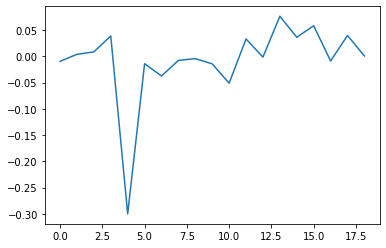

In [280]:
plt.plot(shocks[1:-1])

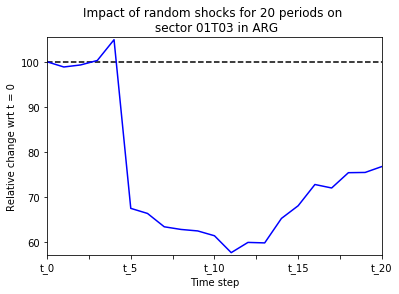

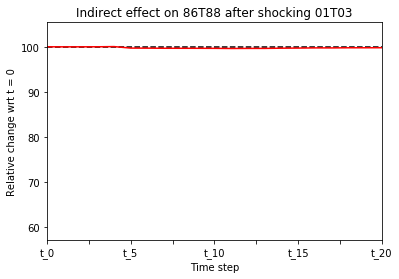

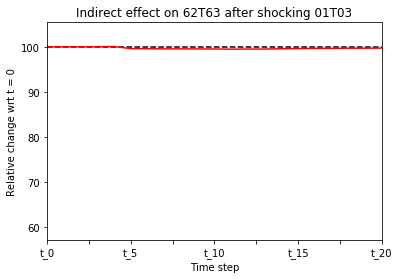

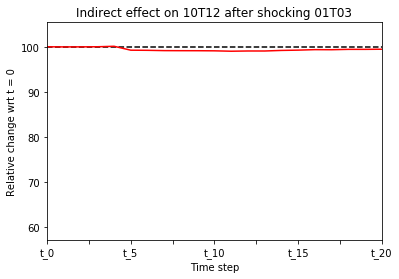

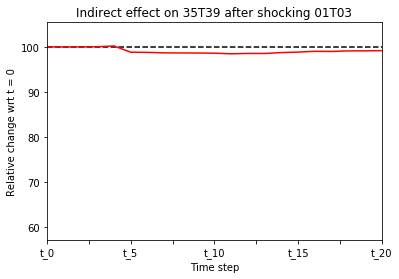

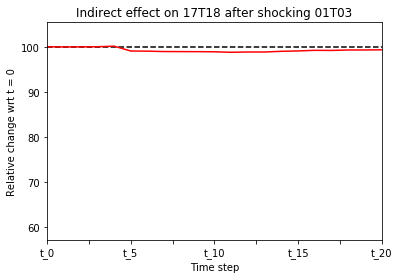

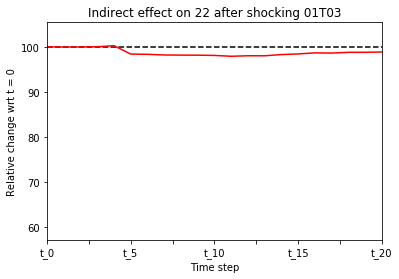

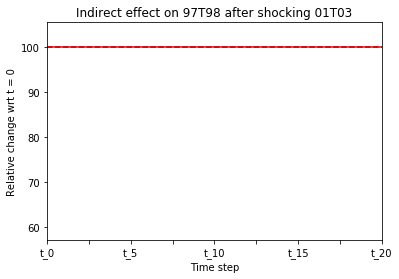

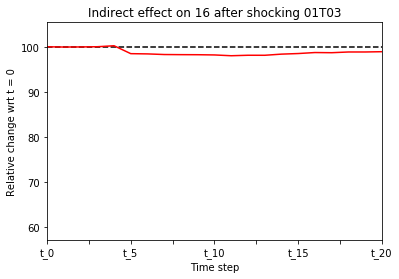

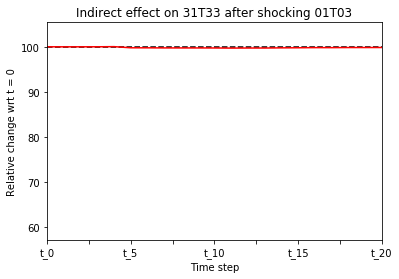

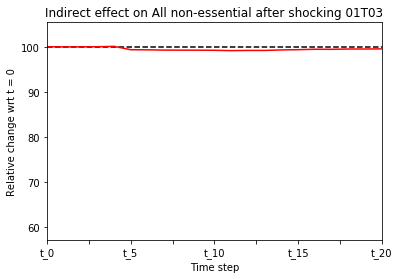

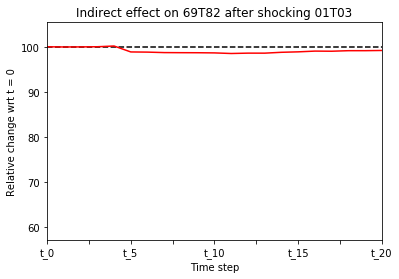

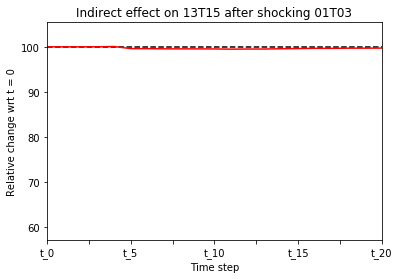

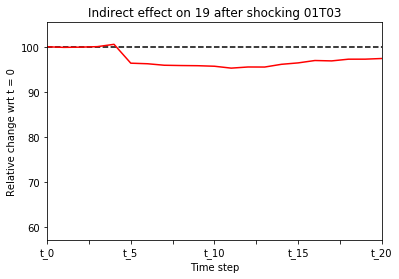

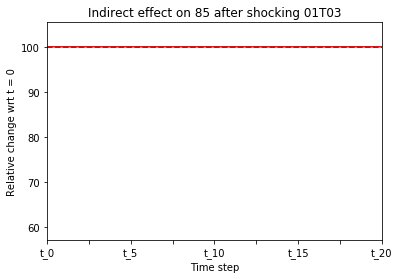

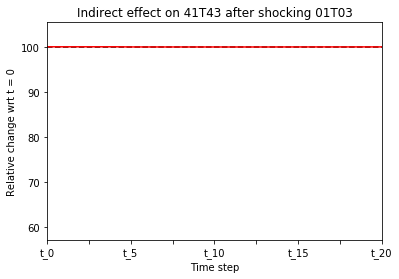

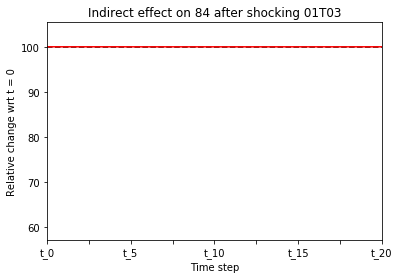

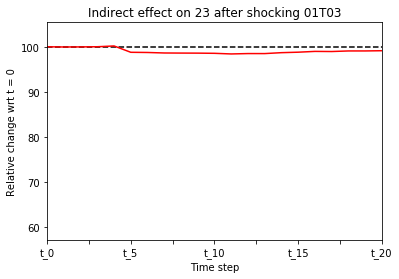

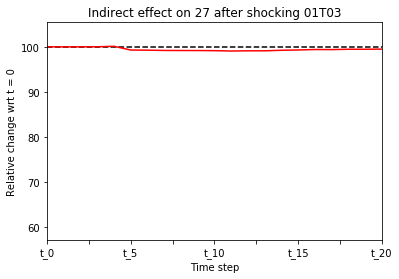

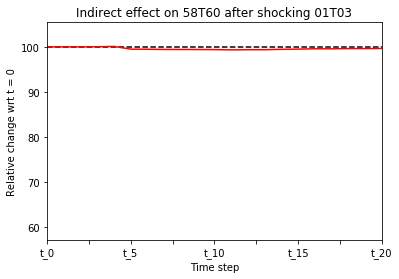

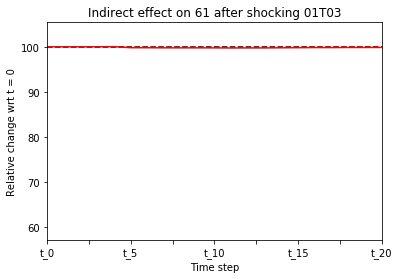

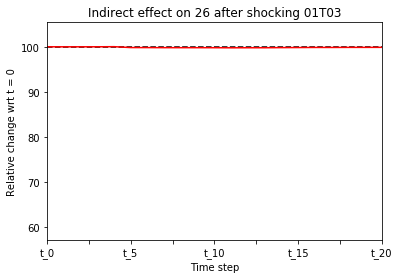

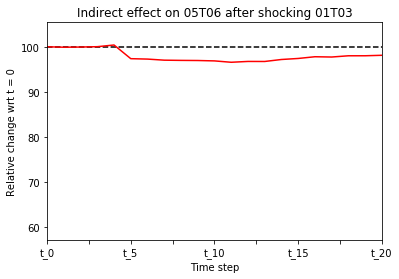

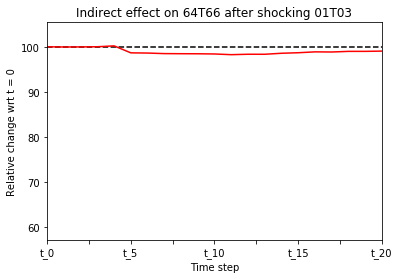

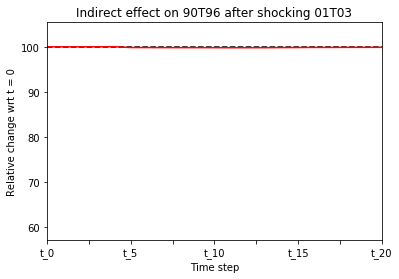

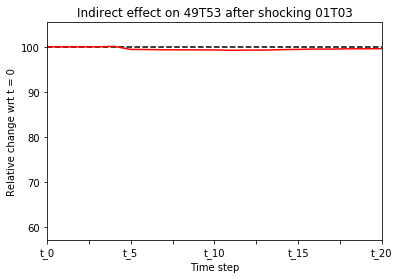

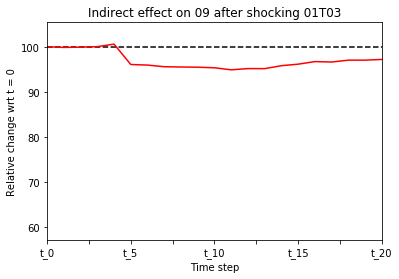

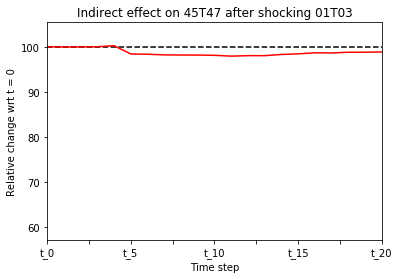

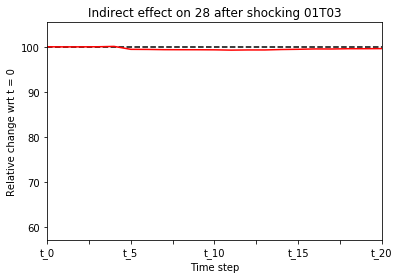

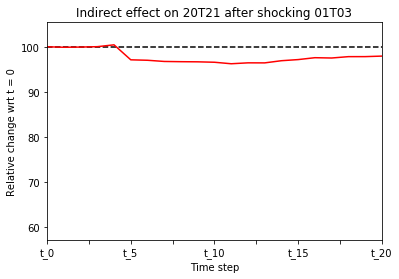

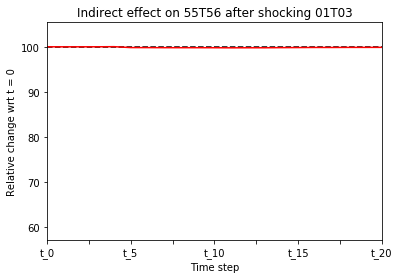

In [281]:
shocked_sector = '01T03'
shocked_country = 'ARG'
other_sectors = list(set(simulation.index.get_level_values(level = 1)))
other_sectors.remove(shocked_sector)

ymin = simulation.loc[(shocked_country, shocked_sector)].min() - 0.5
ymax = simulation.loc[(shocked_country, shocked_sector)].max() + 0.5

simulation.loc[(shocked_country, shocked_sector)].plot(color = 'blue')
plt.hlines(100, 0, 20, colors = 'black', linestyles = 'dashed')
plt.title('Impact of random shocks for 20 periods on \n sector ' + shocked_sector +  ' in ' + shocked_country)
plt.ylabel('Relative change wrt t = 0')
plt.ylim(ymin, ymax)
plt.xlabel('Time step')
plt.show()

for sector in other_sectors:
    
    simulation.loc[(shocked_country, sector)].plot(color = 'red')
    plt.hlines(100, 0, 20, colors = 'black', linestyles = 'dashed')
    plt.title('Indirect effect on ' + sector + ' after shocking ' + shocked_sector)
    plt.ylabel('Relative change wrt t = 0')
    plt.ylim(ymin, ymax)
    plt.xlabel('Time step')
    plt.show()
    